In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from corner import corner
from acor import acor

from matplotlib.colors import LogNorm

%matplotlib inline

def trace_plot(chain, pars,
               cols=3, wid_per_col=4, aspect=4/3,
               kwargs={}):

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].plot(chain[:,pp], **kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig


def hist_plot(chain, pars, bins=30,
              cols=3, wid_per_col=4, aspect=4/3,
              kwargs={}):
    hist_kwargs = {
        'density':True,
        'histtype':'step',
    }
    for key, val in kwargs.items():
        hist_kwargs[key] = val

    rows = len(pars)//cols
    if rows*cols < len(pars):
        rows += 1

    ax = []
    width = wid_per_col * cols
    height = wid_per_col * rows / aspect
    fig = plt.figure(figsize=(width, height))

    for pp, par in enumerate(pars):
        ax.append(fig.add_subplot(rows, cols, pp+1))
        ax[pp].hist(chain[:,pp], bins=bins, **hist_kwargs)
        ax[pp].set_xlabel(par)
    plt.tight_layout()
    return fig

In [4]:
ephem = 'DE436'
bayesephem = True
BE = '_BE' if bayesephem else ''

rundir = '/home/pbaker/nanograv/bwm/allsky/{0:s}{1:s}/detection/'.format(ephem, BE)

In [5]:
with open(rundir + 'params.txt', 'r') as f:
    params = [line.rstrip('\n') for line in f]

# get just bwm params
par_bwm = []
for par in params:
    if par.startswith('bwm_'):
        par_bwm.append(par)
idx_bwm = [params.index(p) for p in par_bwm]
idx_A = par_bwm.index('bwm_log10_A')
idx_t0 = par_bwm.index('bwm_t0')

In [10]:
chain_raw = pd.read_csv(rundir + 'chain_1.txt',
                        sep='\t', dtype=float, header=None).values

In [183]:
burnfrac = 0.10
thin = 10

burn = int(burnfrac * len(chain_raw))
chain = chain_raw[burn::thin]

chain_bwm = chain[:,idx_bwm]
chain_L = chain[:,-4]

corA = acor(chain_bwm[:,idx_A])[0]
N = len(chain_bwm)
print("N = {}, corA = {}".format(N, corA))

N = 50103, corA = 5.525012251662591


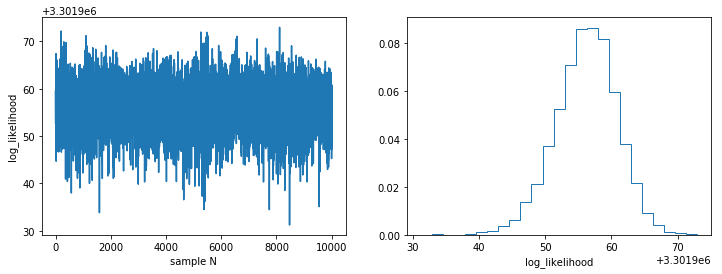

In [20]:
fig = plt.figure(figsize=(12,4))

ax1 = fig.add_subplot(121)
ax1.plot(chain_L)
ax1.set_ylabel('log_likelihood')
ax1.set_xlabel('sample N')

ax2 = fig.add_subplot(122)
ax2.hist(chain_L, bins=25, density=True, histtype='step')
ax2.set_xlabel('log_likelihood');

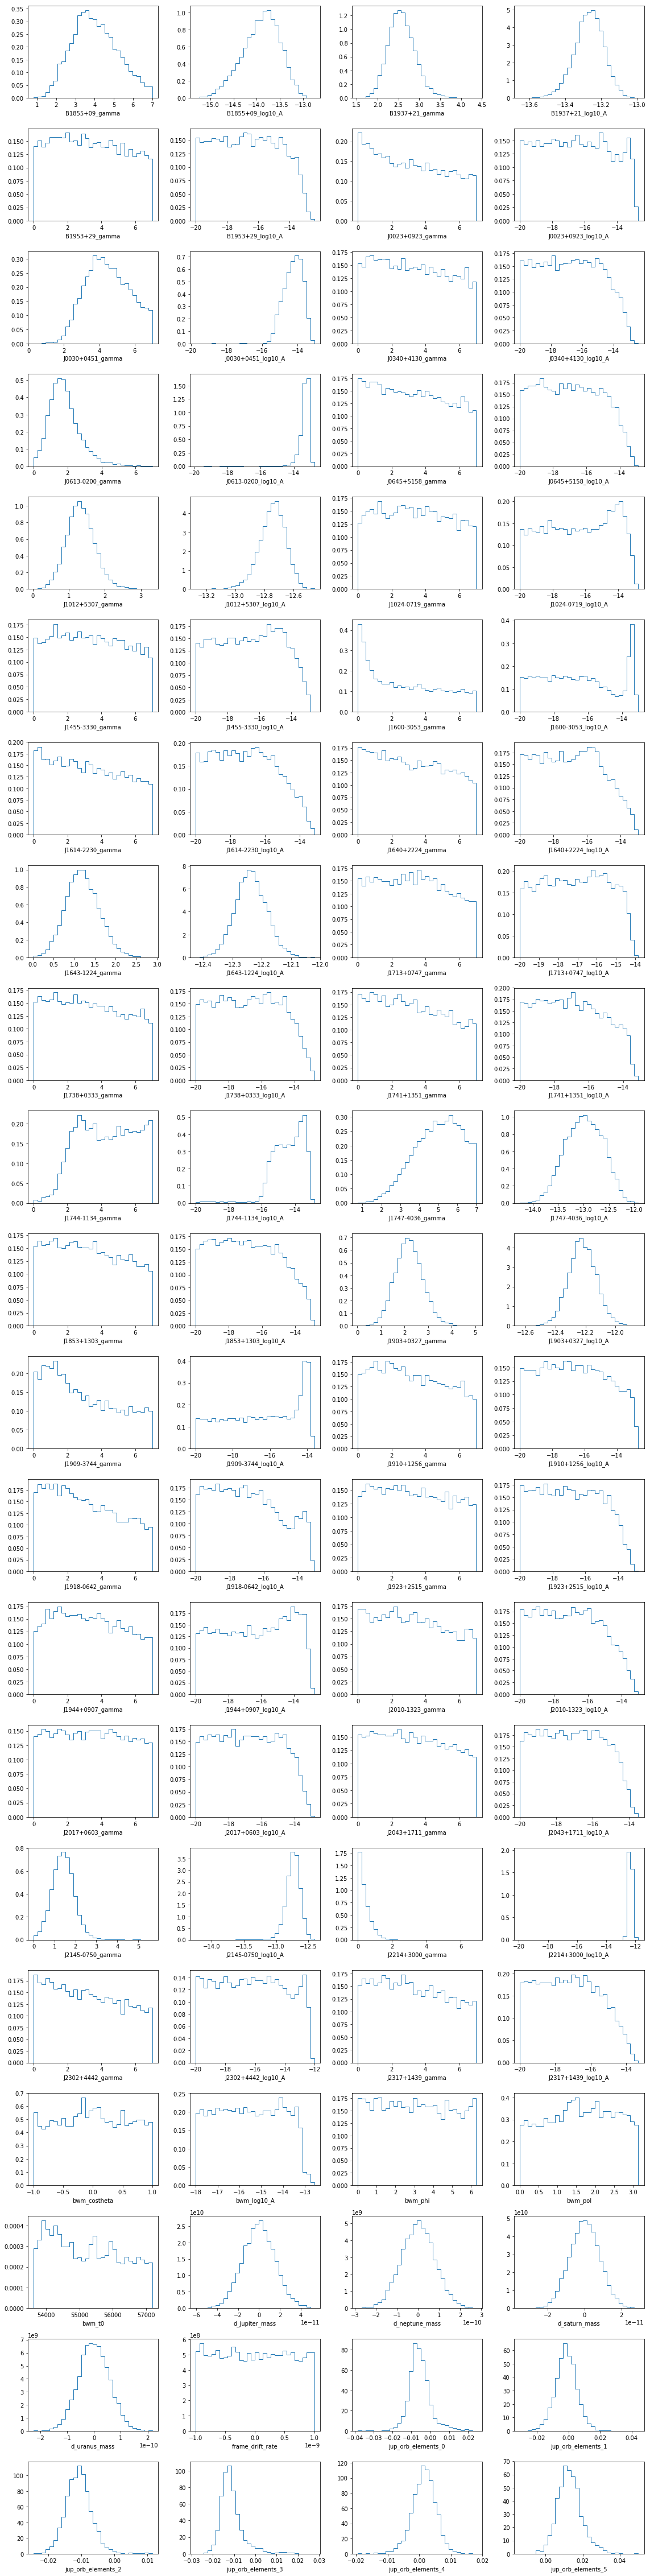

In [21]:
hist_plot(chain[:,:-4], params, cols=4);

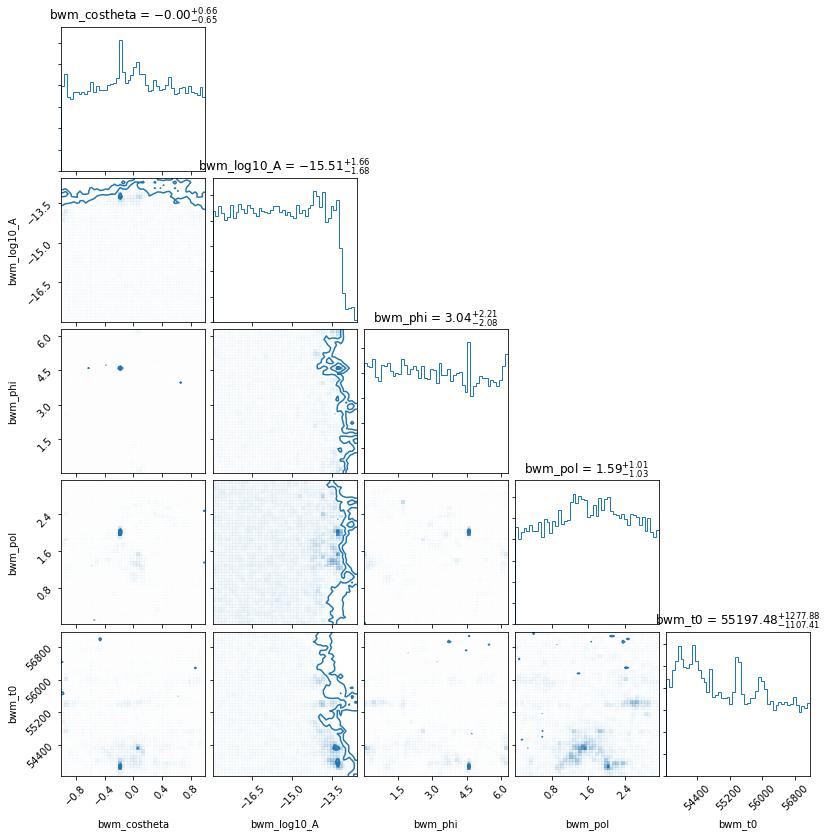

In [184]:
corner_kwargs = {'bins':50,
                 'show_titles':True,
                 'labels':par_bwm,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,
                 'contour_kwargs':{'levels':[1, 10, 100]},}

fig = corner(chain_bwm, color='C0', **corner_kwargs);

Text(0.5, 0, 'log_likelihood')

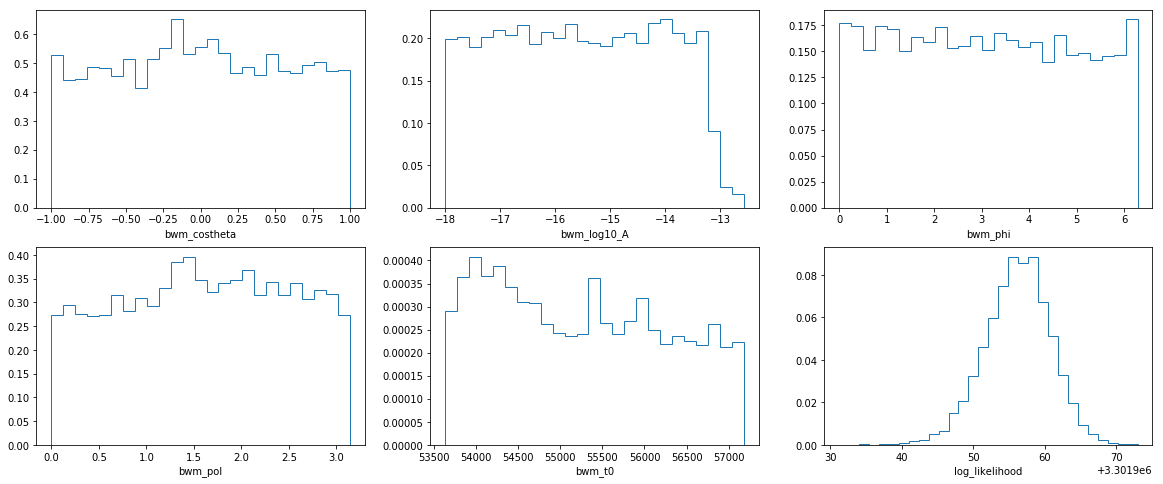

In [30]:
ax = []
fig = plt.figure(figsize=(20,8))

for pp, par in enumerate(par_bwm):
    ax.append(fig.add_subplot(2,3,pp+1))
    ax[pp].hist(chain_bwm[:,pp], bins=25, density=True, histtype='step') #, label='')
    ax[pp].set_xlabel(par)

#ax[0].legend(loc='upper left')
#ax[idx_A].set_yscale('log')
#ax[idx_t0].set_yscale('log')

ax.append(fig.add_subplot(2,3,6))
ax[5].hist(chain[:,-4], bins=30, density=True, histtype='step')
ax[5].set_xlabel('log_likelihood')

In [55]:
def savage_dicke(chain, Amin=-18, Amax=-11,
                 Wmin=0.01, Wmax=3, Nbins=100, Nsamp=100):
    """compute Bayes factor using Savage-Dicke approximation
    Requires uniform prior on log10(Amp)
    """
    prior = 1/(Amax - Amin)
    Ntotal = len(chain)
    wids = np.linspace(Wmin, Wmax, Nbins)
    BF_list = []
    for wid in wids:
        Nsmall = sum(chain < (Amin + wid))
        if Nsmall > Nsamp:
            post = Nsmall / Ntotal / wid
            BF_list.append(prior / post)
    if len(post_list) > 1:
        BF = np.mean(BF_list)
        dBF = np.std(BF_list)
        return BF, dBF
    else:
        msg = "need at least 2 bins with at least {:d} samples".format(Nsamp)
        raise RuntimeError(msg)

In [56]:
savage_dicke(chain_bwm[:,idx_A])

(0.7101093530801114, 0.007119216476436867)

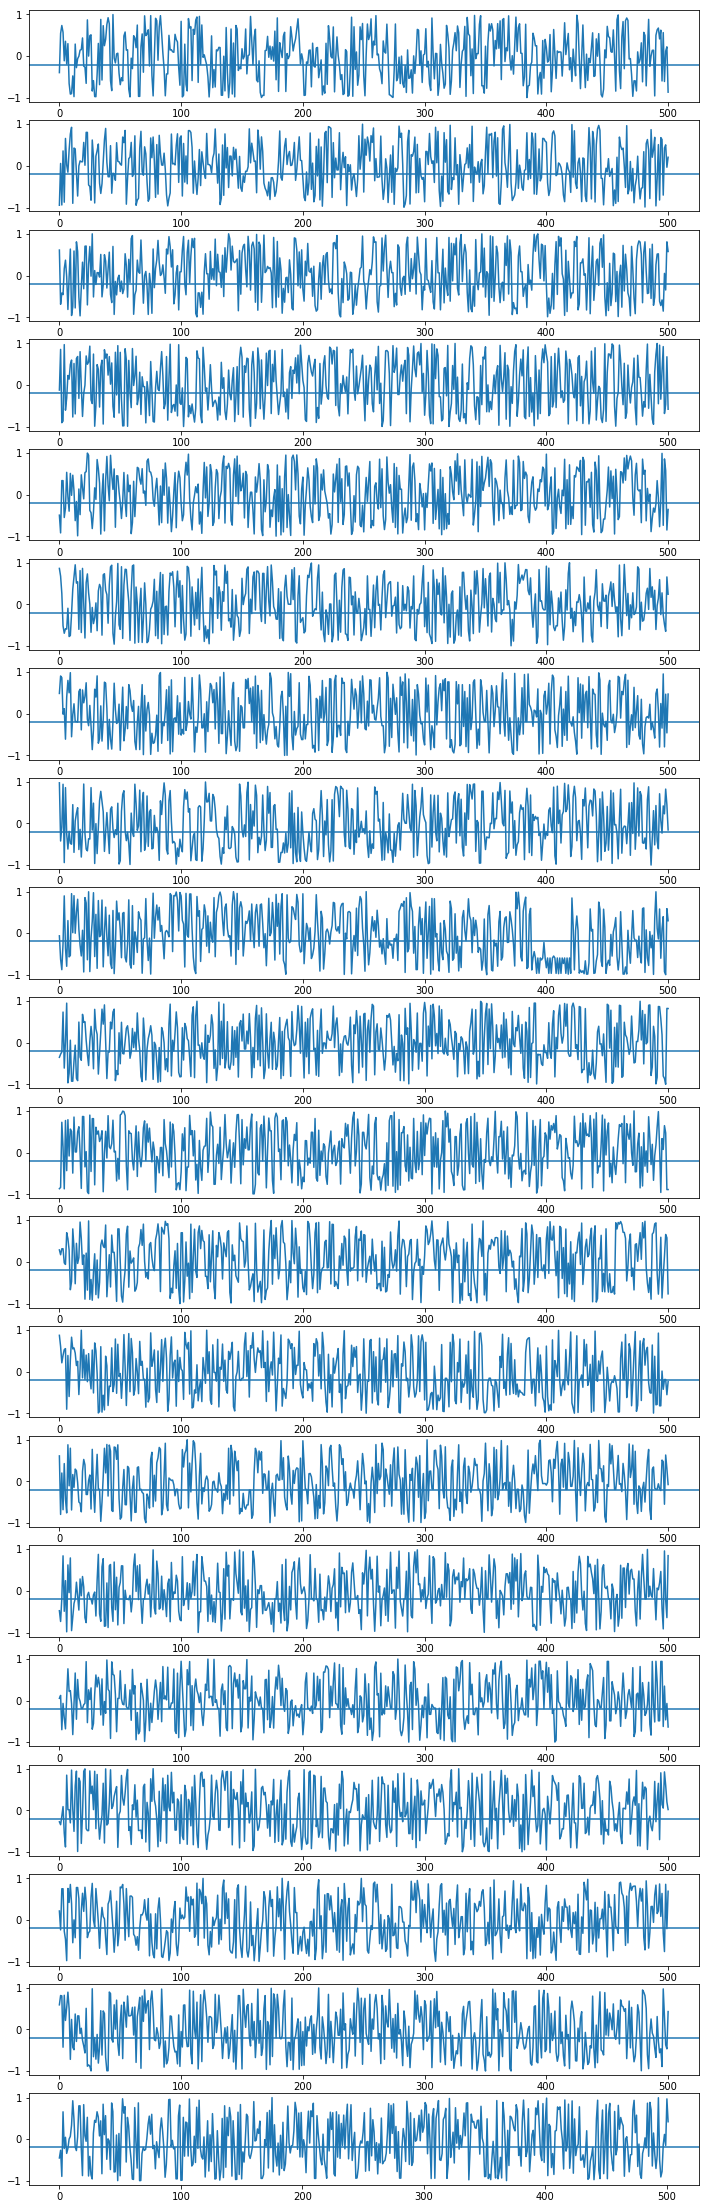

In [93]:
N = len(chain_bwm)

idx = 0
line = -0.2

n = 20
height = 2*n

plt.figure(figsize=(12,height))
for a in range(n):
    b = a+1
    plt.subplot(n,1,b)
    plt.plot(chain_bwm[a*N//n:b*N//n, idx])
    plt.axhline(y=line)


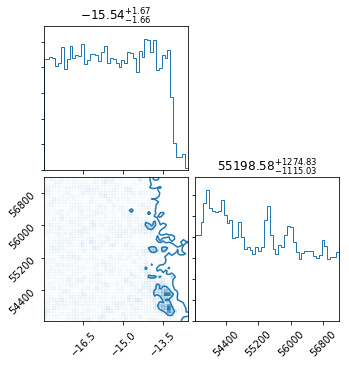

In [181]:
corner_kwargs = {'bins':50,
                 'show_titles':True,
                 'smooth':0.5,
                 'plot_datapoints':False,
                 'plot_density':True,
                 'plot_contours':True,
                 'fill_contours':False,
                 'contour_kwargs':{'levels':[1, 10]},
                }

corner(chain_bwm[:, [1,4]], color='C0', **corner_kwargs);

In [146]:
Nbin = 40
h, xe, ye = np.histogram2d(chain_bwm[:, 1], chain_bwm[:, 2], bins=Nbin)

In [147]:
edges = (xe, ye)

In [148]:
X = -0.21, 4.1
ix, iy = np.divmod(np.argmax(h), Nbin)

X = (xe[ix]+xe[ix+1])/2, (ye[iy]+ye[iy+1])/2
h[ix, iy]

48.0

In [149]:
np.sum(h==0)

150

In [143]:
40*40

1600

# load pulsars for time stuff for paper...

In [191]:
import pickle
from astropy.time import Time
from enterprise import constants as const

In [186]:
# read in data pickles
datafile = '/home/pbaker/nanograv/data/nano11_DE436.pkl'
with open(datafile, "rb") as f:
    psrs = pickle.load(f)

In [194]:
tmin = np.min([p.toas.min() for p in psrs]) / const.day
tmax = np.max([p.toas.max() for p in psrs]) / const.day

tclip = (tmax - tmin) * 0.05

In [197]:
t0min = tmin + tclip*2  # clip first 10%
t0max = tmax - tclip    # last 5%
print(
    Time(t0min, format='mjd').decimalyear,
    Time(t0max, format='mjd').decimalyear
)

2005.7186228467472 2015.427958388402
